In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import datetime as dt
import numpy as np

In [ ]:
gDaysInYear = 365.0  # .242
gSmall = 1e-12
gNotebookMode = False

INVROOT2PI = 0.3989422804014327

In [ ]:
def N(x):
    """ Fast Normal CDF function based on Hull OFAODS  4th Edition Page 252.
    This function is accurate to 6 decimal places. """

    a1 = 0.319381530
    a2 = -0.356563782
    a3 = 1.781477937
    a4 = -1.821255978
    a5 = 1.330274429
    g = 0.2316419

    k = 1.0 / (1.0 + g * np.abs(x))
    k2 = k * k
    k3 = k2 * k
    k4 = k3 * k
    k5 = k4 * k

    if x >= 0.0:
        c = (a1 * k + a2 * k2 + a3 * k3 + a4 * k4 + a5 * k5)
        phi = 1.0 - c * np.exp(-x*x/2.0) * INVROOT2PI
    else:
        phi = 1.0 - N(-x)

    return phi

In [ ]:
def n_vect(x):
    return N(x)

In [ ]:
def bs_delta(s, t, k, r, q, v, p_c):
    """ Price a derivative using Black-Scholes model. """

    if p_c == 'call':
        phi = +1.0
    elif p_c == 'put':
        phi = -1.0

    k = np.maximum(k, gSmall)
    t = np.maximum(t, gSmall)
    v = np.maximum(v, gSmall)

    vsqrtT = v * np.sqrt(t)
    ss = s * np.exp(-q*t)
    kk = k * np.exp(-r*t)
    d1 = np.log(ss/kk) / vsqrtT + vsqrtT / 2.0
    delta = phi * np.exp(-q*t) * n_vect(phi * d1)
    return delta

Desktop Edit

Laptop Edit

In [3]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [4]:
stock_data = pd.read_html(str(table))[0]

In [5]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [6]:
names = [name.replace(".", "-") for name in stock_data.Symbol]

In [7]:
name_query = " ".join(names)

In [15]:
px = yf.download(name_query, start=start_date)

[*********************100%***********************]  503 of 503 completed


In [16]:
px_check = yf.download(name_query, start=start_date)

[*********************100%***********************]  503 of 503 completed


In [18]:
px_check.equals(px)

True

If we have to run a part of the script multiple times to check if correct, thats fine. Add it as a decorator

In [19]:
rets = px.pct_change(1)

Download chain, check if empty, Create DF with name and concat as rows

In [144]:
from concurrent.futures import ThreadPoolExecutor
import itertools

In [274]:
tickers = yf.Tickers(name_query)

In [319]:
def exp_retrieve(name, thread_loop):
    
    try:
    
        tick = tickers.tickers[name]
        t_exp = pd.Series(tick.options, dtype=pd.StringDtype())
        
        t_loop = [x for x in itertools.product([tick], [name], t_exp)]
        
        thread_loop.extend(t_loop)
    
    except:
        
        pass

In [320]:
def option_retrieve(tick, name, exp):
    
    try:
    
        t_book = tick.option_chain(exp)
        t_calls = t_book.calls
        t_puts = t_book.puts
        
        t_calls['callput'] = 'call'
        t_puts['callput'] = 'put'
        
        t_chain = pd.concat([t_calls, t_puts])
        
        t_chain['expiry'] = exp
        t_chain['ticker'] = name
        t_chain['stock_px'] = px['Adj Close'][name].iloc[-1]
        t_chain['stock_ret'] = rets['Adj Close'][name].iloc[-1]
        
        t_chain.reset_index(drop=True, inplace=True)
        
    except:
        
        t_chain = pd.DataFrame()
    
    return t_chain

In [268]:
thread_loop = []

for name in names[:50]:
    
    tick = tickers.tickers[name]
    t_exp = pd.Series(tick.options, dtype=pd.StringDtype())
    
    t_loop = [x for x in itertools.product([tick], [name], t_exp)]
    
    thread_loop.extend(t_loop)

In [325]:
thread_count = 25
name_count = 503

test_frame_3 = pd.DataFrame()

i = 0

while i < 2:

    thread_loop = []

    with ThreadPoolExecutor(thread_count) as executor:
        futures = [executor.submit(exp_retrieve, name, thread_loop) for name in names[:name_count]]
        
    with ThreadPoolExecutor(thread_count) as executor:
        futures = [executor.submit(option_retrieve, tick, name, exp) for tick, name, exp in thread_loop]
        
    thread_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)
    
    test_frame = pd.concat([test_frame, thread_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)], axis = 1)
        
    i+=1

KeyboardInterrupt: 

/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_49851/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  t_chain = pd.concat([t_calls, t_puts])
/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_49851/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  t_chain = pd.concat([t_calls, t_puts])
/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_49851/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these wil

In [1]:
opt_chain

NameError: name 'opt_chain' is not defined

In [324]:
def get_mid_spread(df):
    
    

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,callput,expiry,ticker,stock_px,stock_ret
0,A230120C00060000,2021-11-10 11:48:04+00:00,60.0,67.00,94.6,99.4,0.0,0.0,2.0,2.0,5.659183,True,REGULAR,USD,call,2023-01-20,A,147.669998,-0.029189
1,A230120C00075000,2022-07-22 17:59:00+00:00,75.0,51.44,58.2,60.0,0.0,0.0,2.0,0.0,0.000010,True,REGULAR,USD,call,2023-01-20,A,147.669998,-0.029189
2,A230120C00080000,2022-07-06 16:22:04+00:00,80.0,43.57,54.8,58.4,0.0,0.0,3.0,17.0,0.000010,True,REGULAR,USD,call,2023-01-20,A,147.669998,-0.029189
3,A230120C00085000,2021-11-16 15:10:37+00:00,85.0,77.60,68.5,72.5,0.0,0.0,5.0,6.0,3.597413,True,REGULAR,USD,call,2023-01-20,A,147.669998,-0.029189
4,A230120C00090000,2021-11-10 11:48:04+00:00,90.0,49.10,64.6,69.4,0.0,0.0,1.0,6.0,3.583009,True,REGULAR,USD,call,2023-01-20,A,147.669998,-0.029189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75308,ZTS240119P00210000,2021-11-04 19:23:18+00:00,210.0,31.57,26.8,31.5,0.0,0.0,NaN,6.0,0.000010,True,REGULAR,USD,put,2024-01-19,ZTS,147.639999,0.015057
75309,ZTS240119P00220000,2021-12-27 15:18:46+00:00,220.0,23.30,30.0,34.4,0.0,0.0,NaN,1.0,0.000010,True,REGULAR,USD,put,2024-01-19,ZTS,147.639999,0.015057
75310,ZTS240119P00230000,2021-12-13 05:02:25+00:00,230.0,35.00,35.5,39.5,0.0,0.0,NaN,1.0,0.000010,True,REGULAR,USD,put,2024-01-19,ZTS,147.639999,0.015057
75311,ZTS240119P00260000,2022-07-15 15:38:29+00:00,260.0,87.25,84.5,89.5,0.0,0.0,NaN,0.0,0.000010,True,REGULAR,USD,put,2024-01-19,ZTS,147.639999,0.015057


In [333]:
tickers = yf.Tickers(name_query)

opt_expiries = pd.DataFrame()
opt_chain = pd.DataFrame()

for name in names[:10]:
    
    tick = tickers.tickers[name]
    
    t_exp = pd.Series(tick.options, dtype=pd.StringDtype())
    
    if not t_exp.empty:
    
        for exp in t_exp:
            
            t_book = tick.option_chain(exp)
            t_calls = t_book.calls
            t_puts = t_book.puts
            
            t_calls['callput'] = 'call'
            t_puts['callput'] = 'put'
            
            t_chain = pd.concat([t_calls, t_puts])
            
            t_chain['expiry'] = exp
            t_chain['ticker'] = name
            t_chain['stock_px'] = px['Adj Close'][name].iloc[-1]
            t_chain['stock_ret'] = rets['Adj Close'][name].iloc[-1]
            
            t_chain.reset_index(drop=True, inplace=True)
            
            opt_chain = pd.concat([opt_chain, t_chain])
            
opt_chain.sort_values(['ticker', 'expiry']).reset_index(drop=True, inplace=True)

/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_49851/4129784184.py:32: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  opt_chain = pd.concat([opt_chain, t_chain])
/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_49851/4129784184.py:23: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  t_chain = pd.concat([t_calls, t_puts])


In [334]:
today_array = [dt.date.today().strftime('%Y-%m-%d') for x in opt_chain.index]

In [335]:
opt_chain['k_norm'] = opt_chain['strike'] / opt_chain['stock_px']
opt_chain['1d_delta'] = opt_chain['change'] / 100 / opt_chain['stock_ret']
opt_chain['t_exp'] = np.busday_count(today_array, [x for x in opt_chain['expiry']])

In [336]:
opt_chain['delta_calc'] = opt_chain.apply(lambda x: bs_delta(x.stock_px, x.t_exp/252, x.strike, 0, 0, x.impliedVolatility, x.callput), axis = 1)

In [337]:
ticks = [name for name in opt_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:20].index]

In [338]:
d_curve = opt_chain[(opt_chain['ticker'].isin(ticks)) & (opt_chain['expiry'] == '2023-01-20') & (opt_chain['callput'] == 'call')]

In [339]:
d_curve.ticker.unique()

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP',
       'AAP'], dtype=object)

Have index of np range 0.75 to 1.25 in 0.01 gaps. we dont need to actually mark to market for an option

In [340]:
rebase_index = np.arange(0.75,1.26,0.01)
smaller_index = np.arange(0.9,1.11,0.01)

In [341]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta_calc), index = rebase_index)

    curve_df[tick] = interp_curve

<AxesSubplot: >

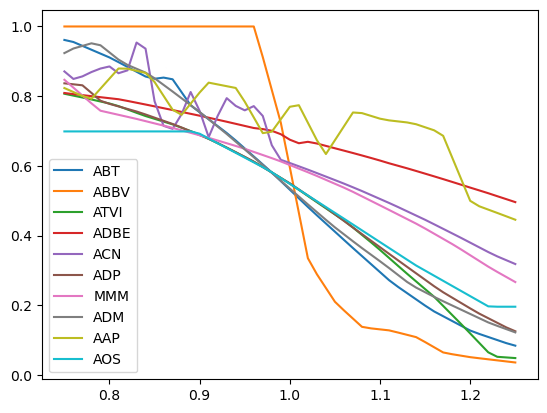

In [342]:
curve_df.plot()